In [1]:
# %load_ext tensorboard
# %tensorboard --logdir runs

%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch import utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter


import os
import sys  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

import sklearn as sk
from sklearn.preprocessing import StandardScaler, QuantileTransformer


In [3]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
    
if IN_COLAB:
    !pip install lightning 
    import lightning.pytorch as pl
    DATA_PATH = '/content/drive/MyDrive/4. MODELS/NTL/data/data.csv'
    
    from google.colab import drive
    drive.mount('/content/drive')

else:
    sys.path.append('/Users/ivan_zorin/Documents/AIRI/code/ntl/')
    DATA_PATH = '/Users/ivan_zorin/Documents/AIRI/data/sgcc/data.csv'
    from data.data import *
    from utils.utils import reduce_embeddings


In [4]:
def get_dataset(filepath):
    """## Saving "flags" """

    df_raw = pd.read_csv(filepath, index_col=0)
    flags = df_raw.FLAG.copy()

    df_raw.drop(["FLAG"], axis=1, inplace=True)

    """## Sorting"""

    df_raw = df_raw.T.copy()
    df_raw.index = pd.to_datetime(df_raw.index)
    df_raw.sort_index(inplace=True, axis=0)
    df_raw = df_raw.T.copy()
    df_raw["FLAG"] = flags
    return df_raw

In [5]:
N_EPOCHS = 100
BATCH_SIZE = 16
LR = 10 ** -5

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
class SGCCDataset(Dataset):
    def __init__(self, path, label=None, scale=None, year=None):
        super(SGCCDataset).__init__()
        self.path = path
        self.label = label
        self.scale = scale
        # loading dataset
        self.data = self._get_dataset()
        self.data = self._filter_by_label(self.data, self.label) # extracting data of only selected class
        self.labels = self.data['FLAG'].to_numpy() # class labels
        self.data = self.data.drop('FLAG', axis=1)
        self._fill_na_() # filling NaN in consumption
        self.consumers = self.data.reset_index()['CONS_NO'].to_list() # names of consumers

        if year:
            #TODO: slice data to have only selected year
            # transpose raw_data and pick year in index
            pass
        
        self.length = self.data.shape[0]
        self.data = self.data.to_numpy()
        if self.scale:
            self.data = self._scale_data()
            
    def _scale_data(self):
        eps = 10 ** -8
        if self.scale == 'minmax':
            _min = self.data.min(axis=1)
            _max = self.data.max(axis=1)
            self.data = (self.data - _min[:, None]) / (_max[:, None] - _min[:, None] + eps)

        elif self.scale == 'standard':
            mean = self.data.mean(axis=1)
            std = self.data.std(axis=1)
            self.data = (self.data - mean[:, None]) / (std[:, None] + eps)
            
        else:
            print('unknow scaler name')
            ValueError

        return self.data

    def _filter_by_label(self, data, label):
        if label in ('normal', 0):
            data = data[data['FLAG'] == 0]
        elif label in ('anomal', 1):
            data = data[data['FLAG'] == 1]
        else:
            pass

        return data

    def _fill_na_(self):
        # filling with zeros
        self.data.fillna(0, inplace=True)

    def _get_dataset(self):
        return get_dataset(self.path)

    def _get_item(self, idx):
        return (self.labels[idx], self.data[idx, :, None].astype(np.float32), self.consumers[idx])

    def __getitem__(self, idx):
        return self._get_item(idx)

    def __len__(self):
        return self.length

In [7]:
class LSTMAE(nn.Module):
    def __init__(self, input_size=1, hidden_size=[64], n_lstms=1, activation_fn=nn.ReLU, **lstm_kwargs):
        super(LSTMAE, self).__init__()
        assert n_lstms == len(hidden_size)

        # self.activation_fn = activation_fn

        # encoder
        encoder, decoder = [], []
        self.enc_dims = [input_size] + hidden_size
        self.dec_dims = self.enc_dims[::-1]

        for i in range(len(self.enc_dims) - 1):
            encoder += [nn.LSTM(input_size=self.enc_dims[i], hidden_size=self.enc_dims[i+1], num_layers=1, batch_first=True, **lstm_kwargs)]

            decoder += [nn.LSTM(input_size=self.dec_dims[i], hidden_size=self.dec_dims[i+1], num_layers=1, batch_first=True, **lstm_kwargs)]

        self.encoder = nn.Sequential(*encoder)
        self.decoder = nn.Sequential(*decoder)


    def forward(self, x):
        N, L, H = x.shape # Batch x Length x Feature size
        # encoding
        _, (hn, _) = self.encoder(x) # latent representation
        hn.transpose_(0, 1) # batch first
        # decoding
        x_hat, (_, _) = self.decoder(hn.expand(-1, L, -1)) # expand to stratch embedding over length of the input

        return (hn.squeeze(1), x_hat.flip(1))


In [8]:
normal_dataset = SGCCDataset(path=DATA_PATH, label=0, scale='minmax')
anomal_dataset = SGCCDataset(path=DATA_PATH, label=1, scale='minmax')

train_data, val_data, test_normal_data = utils.data.random_split(normal_dataset, [len(normal_dataset) - 2*len(anomal_dataset), len(anomal_dataset), len(anomal_dataset)])
test_data = utils.data.ConcatDataset([test_normal_data, anomal_dataset])

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

model = LSTMAE().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
loss_fn = nn.MSELoss()

# logger = SummaryWriter()

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
train_len = len(train_loader)
val_len = len(val_loader)

train_means, train_stds = [], []
val_means, val_stds = [], []

for epoch in range(N_EPOCHS):
    print(f'####### epoch: {epoch+1}/{N_EPOCHS} #######')
    # training step
    train_losses = []
    train_embed = []
    t = tqdm(train_loader)
    model.train()
    for ii, batch in enumerate(t):
        optimizer.zero_grad()
        _, x, _ = batch
        z, x_hat = model(x.to(device))
        loss = loss_fn(x.to(device), x_hat)
        loss.backward()
        optimizer.step()

        # logging
        train_losses.append(loss.item())
        train_embed.append(z.cpu().detach().numpy().squeeze())
        t.set_description(f'Train Loss: {loss.item()}')
        
        step = epoch * train_len + ii
        logger.add_scalar('Loss/Train', loss.item(), step)
        # TODO add embeddings logging

    model.eval()
    val_losses = []
    val_embed = []
    t = tqdm(val_loader)
    for ii, batch in enumerate(t):
        with torch.no_grad():
            y, x, _ = batch
            z, x_hat = model(x.to(device))
            loss = loss_fn(x.to(device), x_hat)
            
            val_losses.append(loss.item())
            val_embed.append(z.cpu().detach().numpy().squeeze())
            t.set_description(f'Val Loss: {loss.item()}')
            step = epoch * val_len + ii
            logger.add_scalar('Loss/Val', loss.item(), step)
            
            
    # test on normal and anomal 

    # avarage metrics after each epoch
    train_losses = np.array(train_losses)
    train_means.append(train_losses.mean())
    train_stds.append(train_losses.std())
    
    val_losses = np.array(val_losses)    
    val_means.append(val_losses.mean())
    val_stds.append(val_losses.std())

        

In [ ]:
# TODO adapt this structure to different encoder-decoder architecture

In [9]:
model_name = 'lstm_ae.ckpt'
model_path = '/Users/ivan_zorin/Google Drive/My Drive/4. MODELS/NTL/' + model_name

model = torch.load(model_path, map_location=device)

In [22]:
def compute_embeddings(model, loader):
    model.eval()
    embeddings = []
    labels = []
    t = tqdm(loader)
    for i, batch in enumerate(t):
        y, x, _ = batch
        labels.append(y.cpu().numpy())
        with torch.no_grad():
            z, x_hat = model(x.to(device))
            
            # loss = loss_fn(x.to(device), x_hat)
            embeddings.append(z.detach().cpu().numpy())
            
    embeddings = np.concatenate(embeddings, axis=0)
    labels = np.concatenate(labels, axis=0)
            
    return labels, embeddings
        

In [19]:
train_labels, train_embeddings = compute_embeddings(model, train_loader)

  0%|          | 0/1971 [00:00<?, ?it/s]

In [21]:
len(train_labels)

1971

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


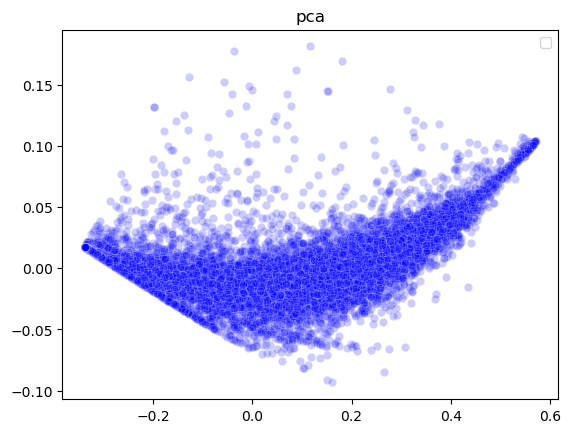

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


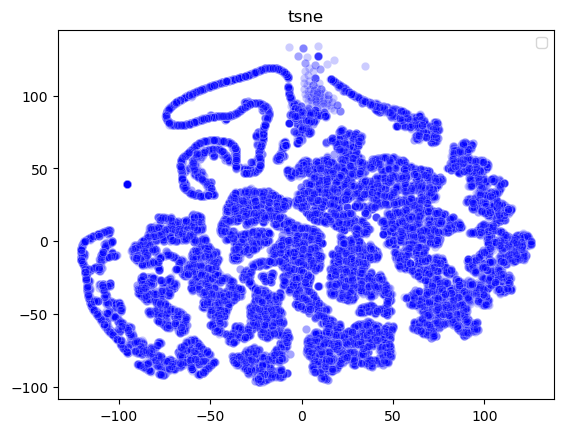

In [15]:
train_embed_2d = reduce_embeddings(embeddings, 'PCA', title='pca train')
# _ = reduce_embeddings(embeddings, 'TSNE', title='tsne train')

  0%|          | 0/226 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


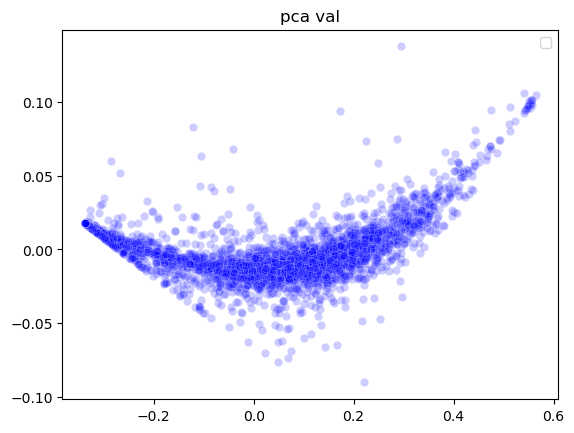

In [23]:
val_labels, val_embeddings = compute_embeddings(model, val_loader)
val_emb_2d = reduce_embeddings(val_embeddings, 'PCA', title='pca val')

RuntimeError: The size of tensor a (16) must match the size of tensor b (7) at non-singleton dimension 0

  0%|          | 0/452 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


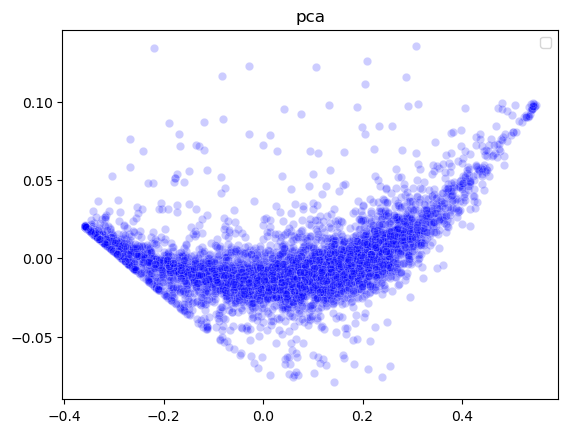

In [17]:
test_labels, test_embeddings = compute_embeddings(model, test_loader)
test_emb_2d = reduce_embeddings(test_embeddings, 'PCA', title='pca test')